# In Wai Cheong (ic2518)
# Homework 2
# COMS 6998 - Practical Deep Learning Systems Performance

In [ ]:
!pip install -q -U tensorflow>=2.2.0
!pip install keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## Question 1

1) Implement the perceptron algorithm without regularization, train it on the 20 points above, and test
its accuracy on 1000 randomly generated points inside the unit square. Generate the test points using
the same procedure as the training points.

2) Change the perceptron criterion to hinge-loss in your implementation for training, and repeat the
accuracy computation on the same test points above. Regularization is not used.

In [ ]:
#Generating Random Points
train_x = np.random.rand(20,2)
train_y = (train_x[:, 0] > train_x[:, 1]).astype(int)
train_y[train_y==0]=-1

##Algorithm
def perceptron_sgd(X, Y):
    w = np.zeros(len(X[0]))
    eta = 1
    epochs = 100

    for t in range(epochs):
        for i, x in enumerate(X):
            if (np.dot(X[i], w)*Y[i]) <= 0:
                w = w + eta*X[i]*Y[i]

    return w

#Training
w = perceptron_sgd(train_x,train_y)
print('Weights:',w)

#Testing on 1000 points
test_x = np.random.rand(1000,2)
test_y = (test_x[:, 0] > test_x[:, 1]).astype(int)
test_y[test_y==0]=-1

y_predicted = []
for i in test_x:
  y_hat = np.dot(w,i)
  y_predicted.append(np.sign(y_hat))

y_predicted = np.asarray(y_predicted)

error = np.unique(y_predicted - test_y,return_counts=True)
print(error,'\n')



#Perceptron with Hinge Loss
def perceptron_hinge(X, Y):
    w = np.zeros(len(X[0]))
    eta = 1
    epochs = 100

    for epoch in range(1,epochs):
        for i, x in enumerate(X):
            if (Y[i]*np.dot(X[i], w)) < 1:
                w = w + eta * ( (X[i] * Y[i]) + (-2  *(1/epoch)* w) )
            else:
                w = w + eta * (-2  *(1/epoch)* w)

    return w

w2 = perceptron_hinge(train_x,train_y)
print('Weights with Hinge Loss:',perceptron_hinge(train_x,train_y))

#Evaluating Hinge-Loss
y_predicted2 = []
for i in test_x:
  y_hat = np.dot(w2,i)
  y_predicted2.append(np.sign(y_hat))

y_predicted2 = np.asarray(y_predicted2)

error = np.unique(y_predicted2 - test_y,return_counts=True)
print(error)

Weights: [ 1.63735903 -1.56579548]
(array([0., 2.]), array([978,  22])) 

Weights with Hinge Loss: [ 3.22093776 -2.50326626]
(array([0., 2.]), array([886, 114]))


3) In which case do you obtain better accuracy and why?
###Answer

The hinge-loss perceptron performs better most of the time compared to the normal perceptron criterion, since correctly classified points also contribute to the loss function.

4) In which case do you think that the classification of the same 1000 test instances will not change
significantly by using a different set of 20 training points?

###Answer
The hinge-loss perceptron criterion will not change much using a different set of 20 training points, since this criterion makes it so that we have maximal separation. The normal perceptron algorithm's decision boundary relies on the training set.

## Question 2

1) Explain vanishing gradients phenomenon using standard normalization with different values of standard
deviation and tanh and sigmoid activation functions. Then show how Xavier (aka Glorot normal)
initialization of weights helps in dealing with this problem. Next use ReLU activation and show that
instead of Xavier initialization, He initialization works better for ReLU activation. You can plot
activations at each of the 5 layers to answer this question.

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras import backend as K

from matplotlib import pyplot as plt
from matplotlib import rcParamsDefault


def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    """
    Iterate through Axes objects on a grid with n_cols columns and as many
    rows as needed to accommodate n_plots many plots.
    Args:
        n_plots: Number of plots to plot onto figure.
        n_cols: Number of columns to divide the figure into.
        fig: Optional figure reference.
    Yields:
        n_plots many Axes objects on a grid.
    """
    n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)

    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(
            default_figsize[0] * n_cols,
            default_figsize[1] * n_rows
        ))

    for i in range(1, n_plots + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        yield ax


def create_mlp_model(
    n_hidden_layers,
    dim_layer,
    input_shape,
    n_classes,
    kernel_initializer,
    bias_initializer,
    activation,
):
    """Create Multi-Layer Perceptron with given parameters."""
    model = Sequential()
    model.add(Dense(dim_layer, input_shape=input_shape, kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    for i in range(n_hidden_layers):
        model.add(Dense(dim_layer, activation=activation, kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer))
    model.add(Dense(n_classes, activation='softmax', kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def create_cnn_model(input_shape, num_classes, kernel_initializer='glorot_uniform',
                     bias_initializer='zeros'):
    """Create CNN model similar to
       https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py."""
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(Conv2D(64, (3, 3), activation='relu',
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def compile_model(model):
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
    return model


def get_init_id(init):
    """
    Returns string ID summarizing initialization scheme and its parameters.
    Args:
        init: Instance of some initializer from keras.initializers.
    """
    try:
        init_name = str(init).split('.')[2].split(' ')[0]
    except:
        init_name = str(init).split(' ')[0].replace('.', '_')

    param_list = []
    config = init.get_config()
    for k, v in config.items():
        if k == 'seed':
            continue
        param_list.append('{k}-{v}'.format(k=k, v=v))
    init_params = '__'.join(param_list)

    return '|'.join([init_name, init_params])


def get_activations(model, x, mode=0.0):
    """Extract activations with given model and input vector x."""
    outputs = [layer.output for layer in model.layers]
    activations = K.function([model.input], outputs)
    output_elts = activations([x, mode])
    return output_elts


class LossHistory(keras.callbacks.Callback):
    """A custom keras callback for recording losses during network training."""

    def on_train_begin(self, logs={}):
        self.losses = []
        self.epoch_losses = []
        self.epoch_val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.epoch_losses.append(logs.get('loss'))
        self.epoch_val_losses.append(logs.get('val_loss'))

11493376/11490434 [==============================] - 0s 0us/step


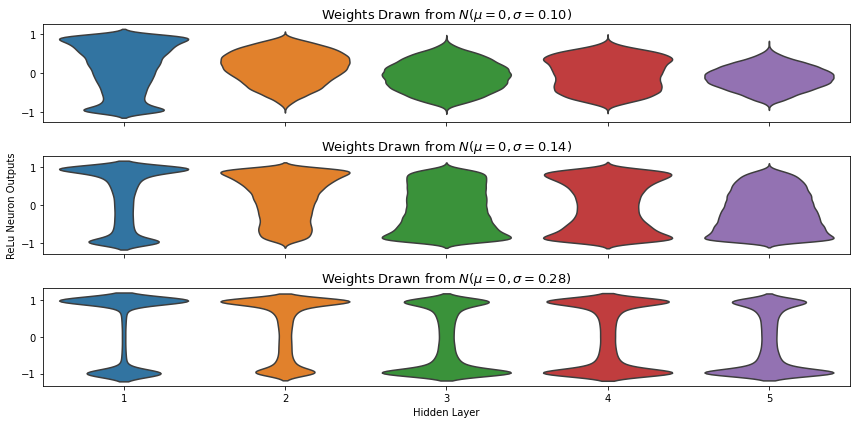

In [ ]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras import initializers
from keras.datasets import mnist



seed = 10

# Number of points to plot
n_train = 1000
n_test = 100
n_classes = 10

# Network params
n_hidden_layers = 5
dim_layer = 100
batch_size = n_train
epochs = 1

# Load and prepare MNIST dataset.
n_train = 60000
n_test = 10000

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))
data_dim = 28 * 28

x_train = x_train.reshape(60000, 784).astype('float32')[:n_train]
x_test = x_test.reshape(10000, 784).astype('float32')[:n_train]
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Run the data through a few MLP models and save the activations from
# each layer into a Pandas DataFrame.
rows = []
sigmas = [0.10, 0.14, 0.28]
for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'tanh'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("ReLu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

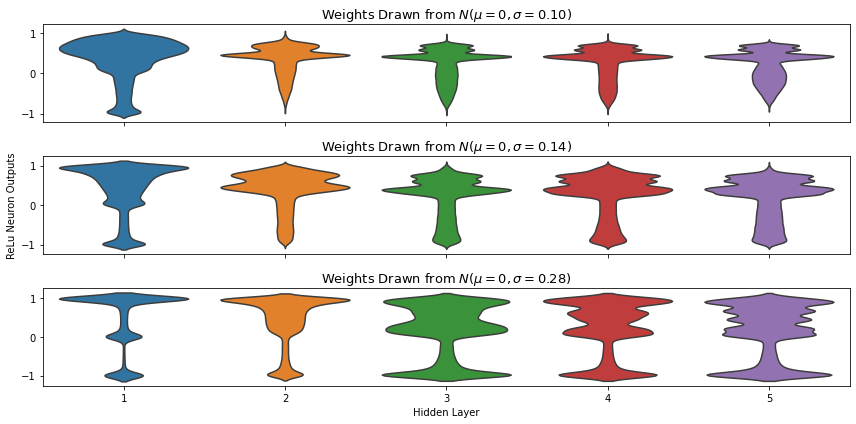

In [ ]:
for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'sigmoid'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("ReLu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

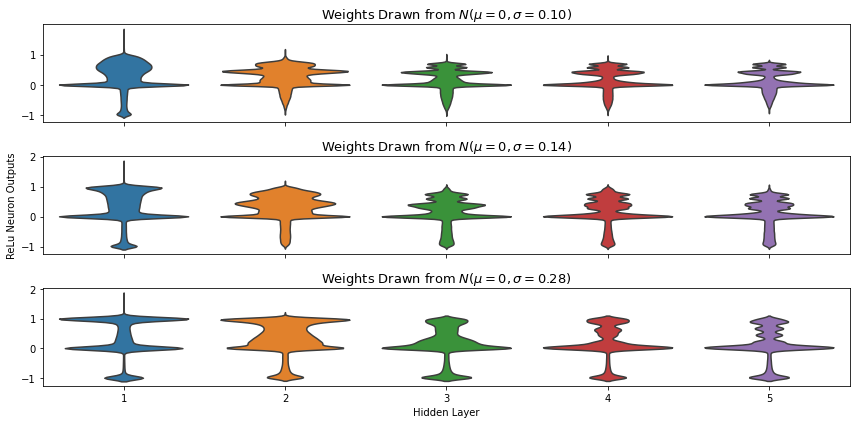

In [ ]:
for stddev in sigmas:
    init = initializers.GlorotNormal(seed=seed)
    activation = 'relu'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("ReLu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

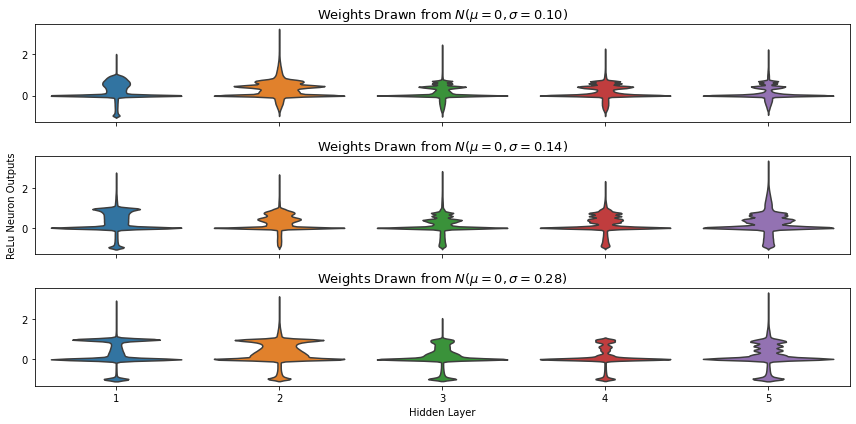

In [ ]:
for stddev in sigmas:
    init = initializers.HeNormal(seed=None)
    activation = 'relu'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("ReLu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

2) The dying ReLU is a kind of vanishing gradient, which refers to a problem when ReLU neurons become
inactive and only output 0 for any input. In the worst case of dying ReLU, ReLU neurons at a certain
layer are all dead, i.e., the entire network dies and is referred as the dying ReLU neural networks in
Lu et al (reference below). A dying ReLU neural network collapses to a constant function. Show this
phenomenon using any one of the three 1-dimensional functions in page 11 of Lu et al. Use a 10-layer
ReLU network with width 2 (hidden units per layer). Use minibatch of 64 and draw training data
uniformly from $[-\sqrt{7},\sqrt{7}]$ Perform 1000 independent training simulations each with 3,000 training
points. Out of these 1000 simulations, what fraction resulted in neural network collapse. Is your
answer close to over 90% as was reported in Lu et al. ?

In [ ]:
from keras import layers
from sklearn.model_selection import train_test_split

x = np.random.uniform(-np.sqrt(7),np.sqrt(7),3000)
y = x*np.sin(5*x)
x = x.reshape(-1,1)
y = y.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=1)

y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

model = keras.Sequential()
model.add(layers.Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(layers.Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(layers.Dense(2, activation='relu',kernel_initializer='HeNormal'))
model.add(layers.Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(layers.Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(layers.Dense(2, activation='relu',kernel_initializer='HeNormal'))
model.add(layers.Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(layers.Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(layers.Dense(2, activation='relu',kernel_initializer='HeNormal'))
model.add(layers.Dense(2,activation = 'softmax'))

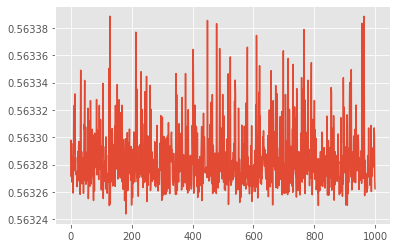

In [ ]:
loss_list = []
iter = range(1000)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

for i in range(1000):
  hist = model.fit(x=X_train,y=y_train, epochs=1, batch_size=64, validation_data=(X_test, y_test), verbose=0)
  loss_list.append(hist.history["loss"][0])

plt.plot(iter,loss_list)

3) Instead of ReLU consider Leaky ReLU activation as defined below:
$$\phi(z)=
\begin{cases}
z & \text{if $z> 0$} \\
0.01z & \text{if $z\leq 0$}
\end{cases}
$$

Run the 1000 training simulations in part 2 with Leaky ReLU activation and keeping everything else
same. Again calculate the fraction of simulations that resulted in neural network collapse. Did Leaky
ReLU help in preventing dying neurons ?

In [ ]:
model = keras.Sequential()

model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))

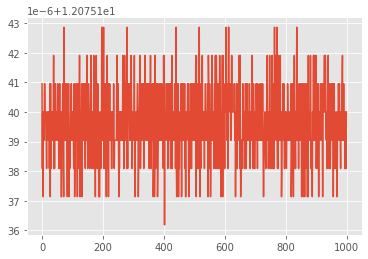

In [ ]:
loss_list = []
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

for i in range(1000):
  hist = model.fit(x=X_train,y=y_train, epochs=1, batch_size=64, validation_data=(X_test, y_test), verbose=0)
  loss_list.append(hist.history["loss"][0])

plt.plot(iter,loss_list)

## Question 3

1) Explain the terms co-adaptation and internal covariance-shift. Use examples if needed. You may need
to refer to two papers mentioned below to answer this question.

### Answer:
Co-adaptation means highly correlated behavior between hidden units in a neural network, and it can be fixed by using dropout.
Internal Covariate Shift is the change in the distribution of network activations due to the change in network parameters during training
and it can be fixed using batch normalization.

2) Batch normalization is traditionally used in hidden layers, for input layer standard normalization is
used. In standard normalization the mean and standard deviation are calculated using the entire
training dataset whereas in batch normalization these statistics are calculated for each mini-batch.
Train LeNet-5 with standard normalization of input and batch normalization for hidden layers. What
are the learned batch norm parameters for each layer ?

### Answer:
The scale parameter and the shift parameter.

In [ ]:
from keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.keras.layers import BatchNormalization
# Load dataset as train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Set numeric type to float32 from uint8
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize value to [0, 1]
x_train /= 255
x_test /= 255

# Transform lables to one-hot encoding
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# Reshape the dataset into 4D array
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

from keras.models import Sequential
from keras import models, layers
import keras
#Instantiate an empty model
model = Sequential()

# C1 Convolutional Layer
model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1), padding='same'))
tf.keras.layers.LayerNormalization(trainable=True)

# S2 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# C3 Convolutional Layer
model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(BatchNormalization(trainable=True))

# S4 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# C5 Fully Connected Convolutional Layer
model.add(layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(BatchNormalization(trainable=True))

#Flatten the CNN output so that we can connect it with fully connected layers
model.add(layers.Flatten())

# FC6 Fully Connected Layer
model.add(layers.Dense(84, activation='tanh'))
model.add(BatchNormalization(trainable=True))

#Output Layer with softmax activation
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])

hist = model.fit(x=x_train,y=y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test), verbose=1)

test_score = model.evaluate(x_test, y_test)
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.3557 - accuracy: 0.8998 - val_loss: 0.2707 - val_accuracy: 0.9305
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2053 - accuracy: 0.9431 - val_loss: 0.1773 - val_accuracy: 0.9494
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1449 - accuracy: 0.9596 - val_loss: 0.1192 - val_accuracy: 0.9665
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1097 - accuracy: 0.9690 - val_loss: 0.1134 - val_accuracy: 0.9668
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0890 - accuracy: 0.9751 - val_loss: 0.0798 - val_accuracy: 0.9760
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0768 - accuracy: 0.9785 - val_loss: 0.0754 - val_accuracy: 0.9759
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0662 - accuracy: 0.9814 - val_loss: 0.0658 - val_accuracy: 0.9810
Epoch 

3) Next instead of standard normalization use batch normalization for input layer also and train the
network. Plot the distribution of learned batch norm parameters for each layer (including input) using
violin plots. Compare the train/test accuracy and loss for the two cases ? Did batch normalization for
input layer improve performance ?

### Answer:
Performance seems to be about the same.

In [ ]:
#Instantiate an empty model
model = Sequential()

# C1 Convolutional Layer
model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1), padding='same'))
model.add(BatchNormalization(trainable=True))

# S2 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# C3 Convolutional Layer
model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(BatchNormalization(trainable=True))

# S4 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# C5 Fully Connected Convolutional Layer
model.add(layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(BatchNormalization(trainable=True))

#Flatten the CNN output so that we can connect it with fully connected layers
model.add(layers.Flatten())

# FC6 Fully Connected Layer
model.add(layers.Dense(84, activation='tanh'))
model.add(BatchNormalization(trainable=True))

#Output Layer with softmax activation
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])

hist = model.fit(x=x_train,y=y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test), verbose=1)

test_score = model.evaluate(x_test, y_test)
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.2766 - accuracy: 0.9212 - val_loss: 0.1857 - val_accuracy: 0.9522
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1261 - accuracy: 0.9646 - val_loss: 0.1000 - val_accuracy: 0.9695
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0926 - accuracy: 0.9749 - val_loss: 0.0783 - val_accuracy: 0.9789
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0753 - accuracy: 0.9788 - val_loss: 0.0697 - val_accuracy: 0.9800
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0650 - accuracy: 0.9821 - val_loss: 0.0593 - val_accuracy: 0.9835
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0578 - accuracy: 0.9837 - val_loss: 0.0573 - val_accuracy: 0.9819
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0526 - accuracy: 0.9852 - val_loss: 0.0498 - val_accuracy: 0.9852
Epoch 

4) Train the network without batch normalization but this time use dropout. For hidden layers use dropout
probability of 0.5 and for input layer take it to be 0.2 Compare test accuracy using dropout to test
accuracy obtained using batch normalization in part 2 and 3.

### Answer:
Accuracy is lower than previous two models.

In [ ]:
#Instantiate an empty model
model = Sequential()

# C1 Convolutional Layer
model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1), padding='same'))
model.add(Dropout(0.2))

# S2 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(Dropout(0.5))

# C3 Convolutional Layer
model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(Dropout(0.5))

# S4 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(Dropout(0.5))

# C5 Fully Connected Convolutional Layer
model.add(layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(Dropout(0.5))

#Flatten the CNN output so that we can connect it with fully connected layers
model.add(layers.Flatten())

# FC6 Fully Connected Layer
model.add(layers.Dense(84, activation='tanh'))
model.add(Dropout(0.5))

#Output Layer with softmax activation
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])

hist = model.fit(x=x_train,y=y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test), verbose=1)

test_score = model.evaluate(x_test, y_test)
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

Epoch 1/10
469/469 [==============================] - 2s 5ms/step - loss: 1.8146 - accuracy: 0.3812 - val_loss: 0.7969 - val_accuracy: 0.8237
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.9957 - accuracy: 0.6746 - val_loss: 0.4796 - val_accuracy: 0.8747
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.8207 - accuracy: 0.7310 - val_loss: 0.4016 - val_accuracy: 0.8899
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.7469 - accuracy: 0.7589 - val_loss: 0.3668 - val_accuracy: 0.8965
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.7097 - accuracy: 0.7709 - val_loss: 0.3480 - val_accuracy: 0.9009
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6879 - accuracy: 0.7804 - val_loss: 0.3314 - val_accuracy: 0.9057
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6610 - accuracy: 0.7925 - val_loss: 0.3165 - val_accuracy: 0.9106
Epoch 

5) Now train the network using both batch normalization and dropout. How does the performance (test
accuracy) of the network compare with the cases with dropout alone and with batch normalization
alone?

### Answer:
Accuracy is better than dropout but lower than batch normalization alone.

In [ ]:
#Instantiate an empty model
model = Sequential()

# C1 Convolutional Layer
model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1), padding='same'))
model.add(BatchNormalization(trainable=True))
model.add(Dropout(0.2))

# S2 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(Dropout(0.5))

# C3 Convolutional Layer
model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(BatchNormalization(trainable=True))
model.add(Dropout(0.5))

# S4 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(Dropout(0.5))

# C5 Fully Connected Convolutional Layer
model.add(layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(BatchNormalization(trainable=True))
model.add(Dropout(0.5))

#Flatten the CNN output so that we can connect it with fully connected layers
model.add(layers.Flatten())

# FC6 Fully Connected Layer
model.add(layers.Dense(84, activation='tanh'))
model.add(BatchNormalization(trainable=True))
model.add(Dropout(0.5))

#Output Layer with softmax activation
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])

hist = model.fit(x=x_train,y=y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test), verbose=1)

test_score = model.evaluate(x_test, y_test)
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

Epoch 1/10
469/469 [==============================] - 3s 6ms/step - loss: 1.3411 - accuracy: 0.5694 - val_loss: 0.3726 - val_accuracy: 0.8949
Epoch 2/10
469/469 [==============================] - 3s 5ms/step - loss: 0.8204 - accuracy: 0.7357 - val_loss: 0.3189 - val_accuracy: 0.9088
Epoch 3/10
469/469 [==============================] - 3s 5ms/step - loss: 0.7050 - accuracy: 0.7752 - val_loss: 0.2868 - val_accuracy: 0.9167
Epoch 4/10
469/469 [==============================] - 3s 5ms/step - loss: 0.6447 - accuracy: 0.7948 - val_loss: 0.2611 - val_accuracy: 0.9243
Epoch 5/10
469/469 [==============================] - 3s 5ms/step - loss: 0.5965 - accuracy: 0.8104 - val_loss: 0.2408 - val_accuracy: 0.9288
Epoch 6/10
469/469 [==============================] - 3s 5ms/step - loss: 0.5584 - accuracy: 0.8238 - val_loss: 0.2194 - val_accuracy: 0.9357
Epoch 7/10
469/469 [==============================] - 3s 5ms/step - loss: 0.5255 - accuracy: 0.8347 - val_loss: 0.2057 - val_accuracy: 0.9384
Epoch 

## Question 4

1) Summarize FashionMNIST dataset, total dataset size, training set size, validation set size, number of
classes, number of images per class. Show any 3 representative images from any 3 classes in the dataset.

### Answer:
Training test size: $60000$ images <br>
Test set size: $10000$ imagess <br>
Total datset: $70000$  images <br>
Number of classes: $10$ different classes, $6000$ images per class for training set, $1000$ images per class for test set <br>

(60000, 28, 28)
(10000,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


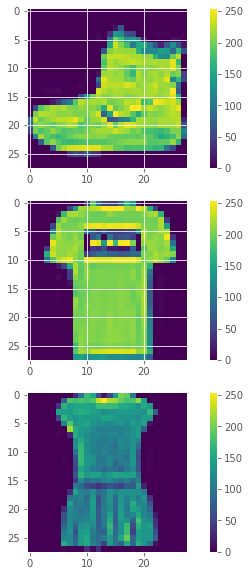

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(x_train.shape)
print(y_test.shape)
print(np.unique(y_train,return_counts=True))
print(np.unique(y_test,return_counts=True))

## 3 Representative Images
fig = plt.figure(figsize=(8,10))
plt.subplot(3,1,1)
plt.imshow(x_train[0])
plt.colorbar()
plt.subplot(3,1,2)
plt.imshow(x_train[1])
plt.colorbar()
plt.subplot(3,1,3)
plt.imshow(x_train[3])
plt.colorbar()
plt.grid(False)
plt.show()

2) Fix batch size to 64 and start with 10 candidate learning rates between $10^{-9}$ and $10^1$ and train your
model for 5 epochs. Plot the training loss as a function of learning rate. You should see a curve like
Figure 3 in reference below. From that figure identify the values of $lr_{min}$ and $lr_{max}$.

In [ ]:
%run clr_callback.py
%run learningratefinder.py
%run minigooglenet.py
%run config.py

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

<Figure size 432x288 with 0 Axes>

In [ ]:
import sys
sys.argv=['']
del sys

ap = argparse.ArgumentParser()
ap.add_argument("-f", "--lr-find", type=int, default=0,
	help="whether or not to find optimal learning rate")
args = vars(ap.parse_args())

In [ ]:
# load the training and testing data
print("[INFO] loading Fashion MNIST data...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
# Fashion MNIST images are 28x28 but the network we will be training
# is expecting 32x32 images
trainX = np.array([cv2.resize(x, (32, 32)) for x in trainX])
testX = np.array([cv2.resize(x, (32, 32)) for x in testX])
# scale the pixel intensities to the range [0, 1]
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0
# reshape the data matrices to include a channel dimension (required
# for training)
trainX = trainX.reshape((trainX.shape[0], 32, 32, 1))
testX = testX.reshape((testX.shape[0], 32, 32, 1))
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range=0.1,
	height_shift_range=0.1, horizontal_flip=True,
	fill_mode="nearest")

[INFO] loading Fashion MNIST data...


In [ ]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=MIN_LR, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


stepSize = STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)
clr = CyclicLR(
	mode='triangular',
	base_lr=1e-10,
	max_lr=10,
	step_size=10)
# train the network
print("[INFO] training network...")
H = model.fit(
	x=aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
	epochs=5,
	callbacks=[clr],
	verbose=1)
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=CLASSES))

[INFO] compiling model...
[INFO] training network...
Epoch 1/5
937/937 [==============================] - 27s 29ms/step - loss: 6.8553 - accuracy: 0.1012 - val_loss: 2.7043 - val_accuracy: 0.1000
Epoch 2/5
937/937 [==============================] - 27s 28ms/step - loss: 2.7573 - accuracy: 0.1002 - val_loss: 2.5814 - val_accuracy: 0.1000
Epoch 3/5
937/937 [==============================] - 27s 28ms/step - loss: 2.7395 - accuracy: 0.1006 - val_loss: 2.7864 - val_accuracy: 0.1000
Epoch 4/5
937/937 [==============================] - 27s 28ms/step - loss: 2.7631 - accuracy: 0.1000 - val_loss: 2.5453 - val_accuracy: 0.1000
Epoch 5/5
937/937 [==============================] - 27s 29ms/step - loss: 2.7515 - accuracy: 0.1004 - val_loss: 2.6326 - val_accuracy: 0.1000
[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.00      0.00      0.00      1000
     trouser       0.00      0.00      0.00      1000
    pullover       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/3
938/938 [==============================] - 25s 26ms/step - loss: 9.3810 - accuracy: 0.0999
Epoch 2/3
938/938 [==============================] - 25s 26ms/step - loss: 9.2699 - accuracy: 0.1000
Epoch 3/3
938/938 [==============================] - 25s 27ms/step - loss: 3.4446 - accuracy: 0.0997


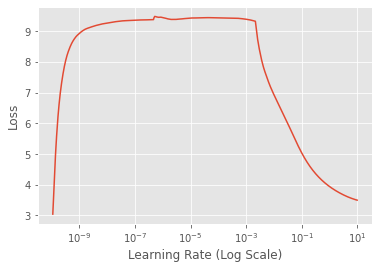

In [ ]:
lrf = LearningRateFinder(model)
lrf.find(
		aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
		1e-10, 1e+1,
		stepsPerEpoch=np.ceil((len(trainX) / float(BATCH_SIZE))),
		batchSize=BATCH_SIZE)

	# plot the loss for the various learning rates and save the
	# resulting plot to disk
lrf.plot_loss()

3) Use the cyclical learning rate policy (with exponential decay) and train your network using batch size
64 and $lr_{min}$ and $lr_{max}$ values obtained in part 1. Plot train/validation loss and accuracy curve (similar
to Figure 4 in reference).

In [ ]:
MIN_LR = 1e-3
MAX_LR = 10

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=MIN_LR, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


stepSize = STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)
clr = CyclicLR(
	mode='triangular',
	base_lr=MIN_LR,
	max_lr=MAX_LR,
	step_size=STEP_SIZE)
# train the network
print("[INFO] training network...")
H = model.fit(
	x=aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
	epochs=5,
	callbacks=[clr],
	verbose=1)
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=CLASSES))

[INFO] compiling model...
[INFO] training network...
Epoch 1/5
937/937 [==============================] - 27s 29ms/step - loss: 2.9242 - accuracy: 0.1021 - val_loss: 2.4483 - val_accuracy: 0.1000
Epoch 2/5
937/937 [==============================] - 26s 28ms/step - loss: 2.8721 - accuracy: 0.0997 - val_loss: 3.7232 - val_accuracy: 0.1000
Epoch 3/5
937/937 [==============================] - 26s 28ms/step - loss: 2.8623 - accuracy: 0.1006 - val_loss: 2.6358 - val_accuracy: 0.1000
Epoch 4/5
937/937 [==============================] - 27s 29ms/step - loss: 2.8043 - accuracy: 0.0991 - val_loss: 2.4960 - val_accuracy: 0.1000
Epoch 5/5
937/937 [==============================] - 27s 28ms/step - loss: 2.8315 - accuracy: 0.0997 - val_loss: 2.7943 - val_accuracy: 0.1000
[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.00      0.00      0.00      1000
     trouser       0.00      0.00      0.00      1000
    pullover       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'Learning Rate')

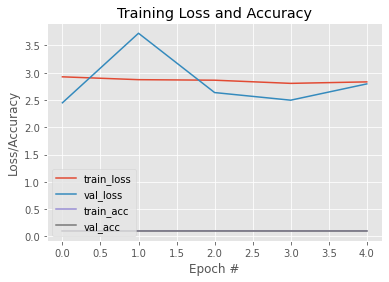

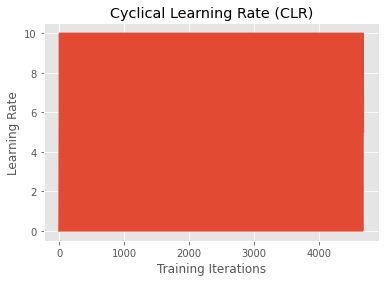

In [ ]:
# construct a plot that plots and saves the training history
N = np.arange(0, 5)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# plot the learning rate history
N = np.arange(0, len(clr.history["lr"]))
plt.figure()
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")

4) Fix learning rate to $lr_{min}$ and train your network starting with batch size 64 and going upto 8192. If
your GPU cannot handle large batch sizes, you can employ effective batch size approach as discussed
in Lecture 3 to simulate large batches. Plot the training loss as a function of batch size. Do you see
a similar behavior of training loss with respect to batch size as seen in part 2 with respect to learning
rate ?

In [ ]:
MIN_LR = 1e-3
MAX_LR = 1e-3
STEP_SIZE = 1

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=MIN_LR, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

batch_size_list = [64,128,256,512,1024,2048,4096]
loss_list = []

for i in batch_size_list:

  stepSize = STEP_SIZE * (trainX.shape[0] // i)
  clr = CyclicLR(
    mode='triangular',
    base_lr=MIN_LR,
    max_lr=MAX_LR,
    step_size=STEP_SIZE)
  # train the network
  print("[INFO] training network...",'Batch Size:',i)
  H = model.fit(
    x=aug.flow(trainX, trainY, batch_size=i),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // i,
    epochs=5,
    callbacks=[clr],
    verbose=1)
  # evaluate the network and show a classification report
  print("[INFO] evaluating network...")
  predictions = model.predict(x=testX, batch_size=i)
  print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=CLASSES))
  loss_list.append(H.history["loss"][4])

[INFO] compiling model...
[INFO] training network... Batch Size: 64
Epoch 1/5
937/937 [==============================] - 377s 403ms/step - loss: 0.8992 - accuracy: 0.6814 - val_loss: 0.6630 - val_accuracy: 0.7510
Epoch 2/5
937/937 [==============================] - 405s 432ms/step - loss: 0.5347 - accuracy: 0.8047 - val_loss: 0.5316 - val_accuracy: 0.8004
Epoch 3/5
937/937 [==============================] - 397s 423ms/step - loss: 0.4488 - accuracy: 0.8373 - val_loss: 0.4572 - val_accuracy: 0.8382
Epoch 4/5
937/937 [==============================] - 398s 424ms/step - loss: 0.4019 - accuracy: 0.8548 - val_loss: 0.3699 - val_accuracy: 0.8678
Epoch 5/5
937/937 [==============================] - 387s 413ms/step - loss: 0.3666 - accuracy: 0.8670 - val_loss: 0.3601 - val_accuracy: 0.8697
[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.74      0.91      0.82      1000
     trouser       0.99      0.97      0.98      1000
    pullover   

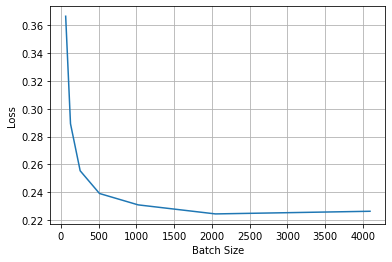

In [ ]:
loss_list = np.asarray(loss_list)
plt.plot(batch_size_list, loss_list)
plt.xlabel('Batch Size')
plt.ylabel('Loss')
plt.grid()

5) Can you identify $b_{min}$ and $b_{max}$ from the figure in part 4 for devising a cyclical batch size policy ?
Create an algorithm for automatically determining batch size and show its steps in a block diagram as
in Figure 1 of reference.

### Answer:
$b_{min}$ is appears to be $0$, and $b_{max}$ seems to be about $2000$ since it appears loss is increasing after that. 

6) Use $b_{min}$ and $b_{max}$ values identified in part 3 and devise a cyclical batch size policy such that the
batch size changes in a cyclical manner between $b_{min}$ and $b_{max}$. In part 3 we did exponential decrease 
in learning rate as training progress. What should be an analogous trajectory for batch size as
training progresses, exponential increase or decrease ? Use cyclical batch size policy (with appropriate
trajectory) and train your network using learning rate $lr_{min}$.

### Answer:
1) Set a very small and very large batch size bounds. <br>
2) Train network <br>
3) Increase batch size in steps of $100$ or $200$ after each update. <br>
4) Record loss & batch size at the end, train fro 3-5 epochs <br>
5) Plot loss & batch size <br>
6) Examine plot and identify the optimal batch size <br>
7) Update the batch size(s) <br>
8) Train network on full set of data/epochs

7) Compare the best accuracy from the two cyclical policies. Which policy gives you the best accuracy?

### Answer:
Cyclical learning rate

## Sources Used

https://maviccprp.github.io/a-perceptron-in-just-a-few-lines-of-python-code/ <br>

https://maviccprp.github.io/a-support-vector-machine-in-just-a-few-lines-of-python-code/ <br>